# 🧹 Data Preprocessing Mastery: From Messy to Model-Ready

<img src='https://daxg39y63pxwu.cloudfront.net/images/blog/data-preprocessing-techniques-and-steps/data_preprocessing.webp' width='600' alt='Data Preprocessing'>


## 🎯 The Most Important Step in Data Science

**80% of data science is data cleaning!** This notebook will teach you:
- Handle **missing data** like a pro
- Deal with **outliers** effectively
- **Transform** data for better models
- **Engineer** powerful features
- Build **reproducible pipelines**

### 📚 What We'll Master Today:
1. **Data Quality Assessment** - Understanding your mess
2. **Missing Data Strategies** - Smart imputation
3. **Outlier Detection & Treatment** - Finding anomalies
4. **Data Transformation** - Scaling and normalization
5. **Feature Engineering** - Creating powerful features
6. **Encoding Categorical Data** - Handling text data
7. **Feature Selection** - Choosing what matters
8. **Data Balancing** - Handling imbalanced data
9. **Pipeline Creation** - Automating everything
10. **Real Project** - End-to-end preprocessing

---

## 🚀 Let's Clean Some Data!

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for beautiful plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("🧹 Data Preprocessing Mastery - Ready to Clean!")
print("\n💡 Remember: Garbage in, garbage out! Quality preprocessing = Quality models! ")

c:\Users\RC\miniconda3\envs\ML_Python\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


🧹 Data Preprocessing Mastery - Ready to Clean!

💡 Remember: Garbage in, garbage out! Quality preprocessing = Quality models! 


---

## 📌 Section 1: Data Quality Assessment

### 🎯 Know Your Data's Problems

In [2]:
# 1.1 Create a Messy Dataset (Realistic!)
print("🎭 CREATING REALISTIC MESSY DATA\n" + "="*40)

np.random.seed(42)
n_samples = 1000

# Create messy customer data
data = {
    'customer_id': range(1000, 1000 + n_samples),
    'age': np.random.normal(35, 15, n_samples),
    'income': np.random.lognormal(10.5, 0.5, n_samples),
    'credit_score': np.random.normal(650, 100, n_samples),
    'purchase_amount': np.random.exponential(100, n_samples),
    'membership_days': np.random.uniform(0, 1000, n_samples),
    'gender': np.random.choice(['M', 'F', 'Male', 'Female', 'male', 'female', None], n_samples),
    'city': np.random.choice(['New York', 'new york', 'NY', 'Los Angeles', 'LA', 'Chicago', None], n_samples),
    'email': [f'user{i}@email.com' if np.random.random() > 0.1 else None for i in range(n_samples)],
    'phone': [f'555-{np.random.randint(1000, 9999)}' if np.random.random() > 0.15 else None for i in range(n_samples)],
    'has_children': np.random.choice(['Yes', 'No', 'Y', 'N', '1', '0', None], n_samples),
    'satisfaction_score': np.random.choice([1, 2, 3, 4, 5, None], n_samples),
    'last_purchase_date': pd.date_range('2020-01-01', periods=n_samples, freq='D'),
    'premium_customer': np.random.choice([True, False], n_samples)
}

df = pd.DataFrame(data)

# Add more messiness
# Add missing values randomly
for col in ['age', 'income', 'credit_score']:
    missing_idx = np.random.choice(df.index, size=int(0.1 * len(df)), replace=False)
    df.loc[missing_idx, col] = np.nan

# Add outliers
outlier_idx = np.random.choice(df.index, size=50, replace=False)
df.loc[outlier_idx, 'income'] = df.loc[outlier_idx, 'income'] * 10
df.loc[outlier_idx[:25], 'age'] = np.random.uniform(100, 120, 25)

# Add duplicates
duplicate_rows = df.sample(20)
df = pd.concat([df, duplicate_rows], ignore_index=True)

# Add inconsistent data
df.loc[df['age'] < 0, 'age'] = np.abs(df.loc[df['age'] < 0, 'age'])

print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:")
print(df.dtypes.value_counts())
print(f"\nMissing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nDuplicates: {df.duplicated().sum()}")

# Display first few rows
print("\n 📋 First 5 Rows:")
df.head()

🎭 CREATING REALISTIC MESSY DATA
📊 Dataset Info:
Shape: (1020, 14)

Data Types:
object            6
float64           5
int64             1
datetime64[ns]    1
bool              1
Name: count, dtype: int64

Missing Values:
age                    98
income                103
credit_score          102
gender                153
city                  136
email                 111
phone                 148
has_children          147
satisfaction_score    189
dtype: int64

Duplicates: 20

 📋 First 5 Rows:


,customer_id,age,income,credit_score,purchase_amount,membership_days,gender,city,email,phone,has_children,satisfaction_score,last_purchase_date,premium_customer
0,1000,42.450712,73106.877027,582.482173,170.782408,909.429504,Female,LA,user0@email.com,555-1496,N,1,2020-01-01,True
1,1001,32.926035,57659.877200,635.548133,410.847634,190.128766,male,None,None,555-7828,N,2,2020-01-02,True
2,1002,44.715328,37414.558971,570.758008,30.066038,821.250155,Male,LA,user2@email.com,555-1493,Y,4,2020-01-03,False
3,1003,57.845448,26279.162694,619.203847,349.738783,544.630871,F,LA,user3@email.com,555-2426,Y,1,2020-01-04,False
4,1004,NaN,51488.391671,NaN,56.428595,77.856520,M,None,user4@email.com,555-3723,1,5,2020-01-05,False


📊 DATA QUALITY ASSESSMENT
                Column            Type  Missing  Missing%  Unique  Unique%          Mean           Std          Min             Max Outliers
0          customer_id           int64        0      0.00    1000    98.04   1498.755882    288.822513         1000            1999        0
1                  age         float64       98      9.61     902    88.43     37.474915     18.989402     0.471183       118.95213       29
2               income         float64      103     10.10     900    88.24  61036.602729  94312.965825  8348.237207  1024409.009188       67
3         credit_score         float64      102     10.00     900    88.24    653.439376     98.987029   348.048784     1042.623771       12
4      purchase_amount         float64        0      0.00    1000    98.04     97.748126     99.194145     0.003072      609.655355       57
5      membership_days         float64        0      0.00    1000    98.04     498.08554    290.321191     0.943415        999.3

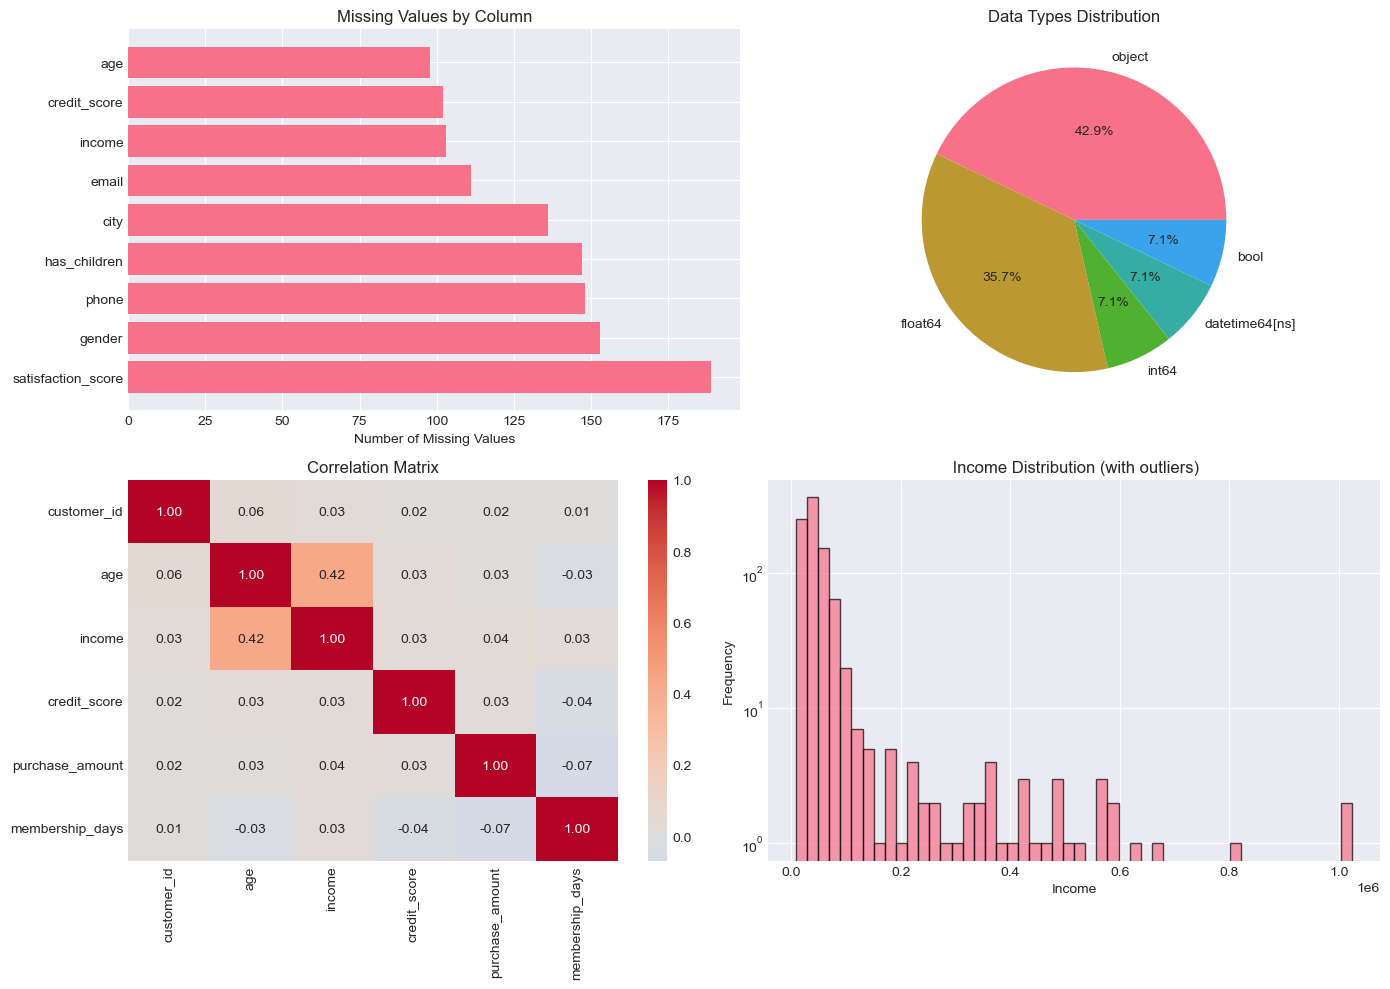

In [3]:
# 1.2 Data Quality Report
print("📊 DATA QUALITY ASSESSMENT\n" + "="*40)

def data_quality_report(df):
    """Generate comprehensive data quality report"""
    
    report = pd.DataFrame({
        'Column': df.columns,
        'Type': df.dtypes.values,
        'Missing': df.isnull().sum().values,
        'Missing%': (df.isnull().sum() / len(df) * 100).round(2).values,
        'Unique': df.nunique().values,
        'Unique%': (df.nunique() / len(df) * 100).round(2).values
    })
    
    # Add statistics for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    stats_dict = {
        'Mean': [],
        'Std': [],
        'Min': [],
        'Max': [],
        'Outliers': []
    }
    
    for col in df.columns:
        if col in numeric_cols:
            stats_dict['Mean'].append(df[col].mean())
            stats_dict['Std'].append(df[col].std())
            stats_dict['Min'].append(df[col].min())
            stats_dict['Max'].append(df[col].max())
            
            # Count outliers (using IQR method)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
            stats_dict['Outliers'].append(outliers)
        else:
            for key in stats_dict:
                stats_dict[key].append('-')
    
    for key, values in stats_dict.items():
        report[key] = values
    
    return report

quality_report = data_quality_report(df)
print(quality_report.to_string())

# Visualize data quality
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Missing values heatmap
ax = axes[0, 0]
missing_data = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
ax.barh(range(len(missing_data)), missing_data.values)
ax.set_yticks(range(len(missing_data)))
ax.set_yticklabels(missing_data.index)
ax.set_xlabel('Number of Missing Values')
ax.set_title('Missing Values by Column')

# Data types distribution
ax = axes[0, 1]
type_counts = df.dtypes.value_counts()
ax.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
ax.set_title('Data Types Distribution')

# Correlation heatmap (numeric only)
ax = axes[1, 0]
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation Matrix')

# Distribution of a numeric column
ax = axes[1, 1]
ax.hist(df['income'].dropna(), bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_title(' Income Distribution (with outliers)')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

---

## 📌 Section 2: Handling Missing Data

### 🎯 Smart Strategies for Missing Values

🔍 MISSING DATA ANALYSIS


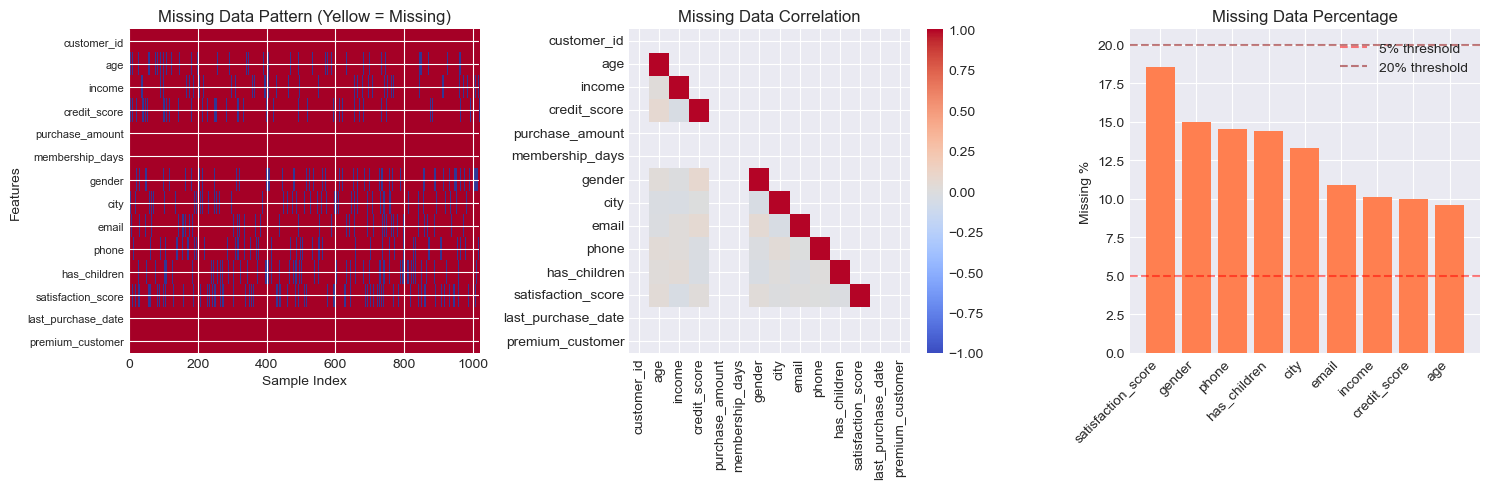


📊 Missing Data Types:
• MCAR (Missing Completely At Random): No pattern
• MAR (Missing At Random): Pattern related to other variables
• MNAR (Missing Not At Random): Pattern related to missing value itself


In [4]:
# 2.1 Missing Data Patterns
print("🔍 MISSING DATA ANALYSIS\n" + "="*40)

# Visualize missing data patterns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Missing data matrix
ax = axes[0]
missing_matrix = df.isnull().astype(int)
ax.imshow(missing_matrix.T, cmap='RdYlBu', aspect='auto', interpolation='none')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Features')
ax.set_title('Missing Data Pattern (Yellow = Missing)')
ax.set_yticks(range(len(df.columns)))
ax.set_yticklabels(df.columns, fontsize=8)

# Missing data correlation
ax = axes[1]
missing_corr = missing_matrix.corr()
mask = np.triu(np.ones_like(missing_corr), k=1)
sns.heatmap(missing_corr, mask=mask, annot=False, cmap='coolwarm', 
            center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Missing Data Correlation')

# Missing data by column
ax = axes[2]
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)
ax.bar(range(len(missing_pct)), missing_pct.values, color='coral')
ax.set_xticks(range(len(missing_pct)))
ax.set_xticklabels(missing_pct.index, rotation=45, ha='right')
ax.set_ylabel('Missing %')
ax.set_title('Missing Data Percentage')
ax.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='5% threshold')
ax.axhline(y=20, color='darkred', linestyle='--', alpha=0.5, label='20% threshold')
ax.legend()

plt.tight_layout()
plt.show()

# Missing data types
print("\n📊 Missing Data Types:")
print("• MCAR (Missing Completely At Random): No pattern")
print("• MAR (Missing At Random): Pattern related to other variables")
print("• MNAR (Missing Not At Random): Pattern related to missing value itself")

🔧 IMPUTATION STRATEGIES
1️⃣ Simple Imputation:
  age: Imputed 98 values with median = 35.99
  income: Imputed 103 values with median = 38684.33
  credit_score: Imputed 102 values with mean = 653.44
  gender: Imputed 153 values with mode = F
  city: Imputed 136 values with mode = new york
  email: Imputed 111 values with mode = user182@email.com
  phone: Imputed 148 values with mode = 555-3939
  has_children: Imputed 147 values with mode = N
  satisfaction_score: Imputed 189 values with mode = 2

 2️⃣ Advanced Imputation - KNN:


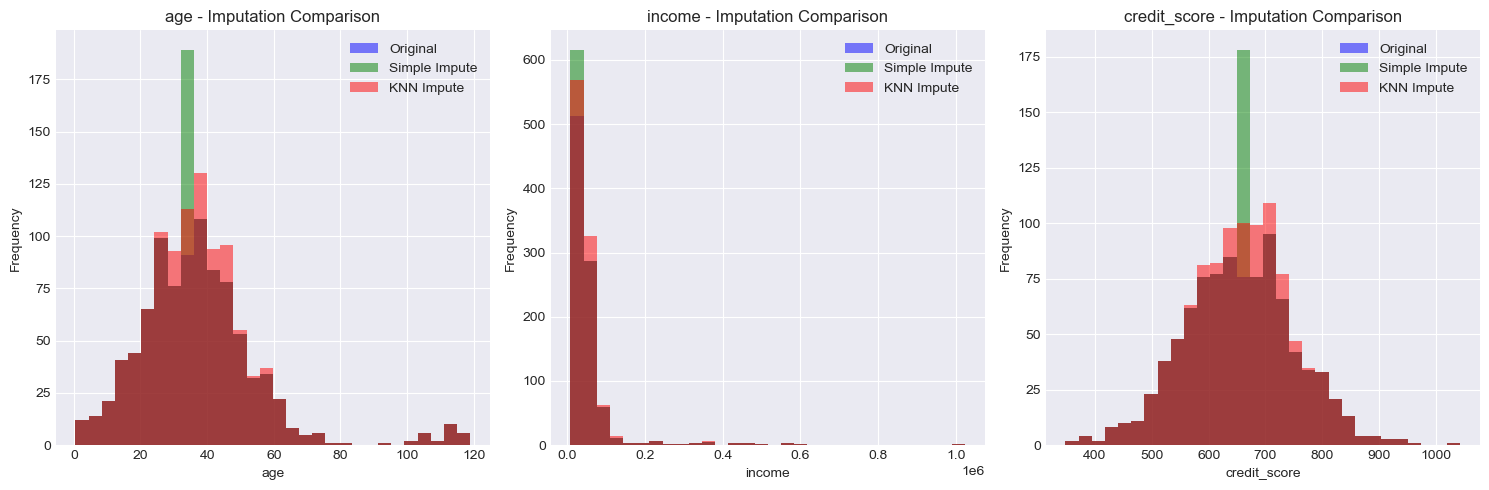


💡 When to use which strategy:
• Mean/Median: When data is MCAR, small % missing
• Mode: For categorical variables
• KNN: When data is MAR, preserves relationships
• Forward/Backward fill: For time series
• Domain-specific: Use business knowledge


In [5]:
# 2.2 Imputation Strategies
print("🔧 IMPUTATION STRATEGIES\n" + "="*40)

# Create a copy for imputation
df_imputed = df.copy()

# Strategy 1: Simple Imputation
print("1️⃣ Simple Imputation:")

# Numeric columns - mean/median imputation
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_imputed[col].isnull().sum() > 0:
        # Use median for skewed data, mean for normal
        skewness = df_imputed[col].skew()
        if abs(skewness) > 1:
            impute_value = df_imputed[col].median()
            strategy = 'median'
        else:
            impute_value = df_imputed[col].mean()
            strategy = 'mean'
        
        missing_count = df_imputed[col].isnull().sum()
        df_imputed[col].fillna(impute_value, inplace=True)
        print(f"  {col}: Imputed {missing_count} values with {strategy} = {impute_value:.2f}")

# Categorical columns - mode imputation
categorical_cols = df_imputed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_imputed[col].isnull().sum() > 0:
        mode_value = df_imputed[col].mode()[0] if not df_imputed[col].mode().empty else 'Unknown'
        missing_count = df_imputed[col].isnull().sum()
        df_imputed[col].fillna(mode_value, inplace=True)
        print(f"  {col}: Imputed {missing_count} values with mode = {mode_value}")

print("\n 2️⃣ Advanced Imputation - KNN:")

# Demonstrate KNN imputation on numeric data
from sklearn.impute import KNNImputer

# Select numeric columns with missing values for demonstration
demo_cols = ['age', 'income', 'credit_score']
df_knn = df[demo_cols].copy()

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(
    imputer.fit_transform(df_knn),
    columns=demo_cols,
    index=df_knn.index
)

# Compare imputation methods
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(demo_cols):
    ax = axes[idx]
    
    # Original distribution
    ax.hist(df[col].dropna(), bins=30, alpha=0.5, label='Original', color='blue')
    
    # Simple imputation
    ax.hist(df_imputed[col], bins=30, alpha=0.5, label='Simple Impute', color='green')
    
    # KNN imputation
    ax.hist(df_knn_imputed[col], bins=30, alpha=0.5, label='KNN Impute', color='red')
    
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col} - Imputation Comparison')
    ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 When to use which strategy:")
print("• Mean/Median: When data is MCAR, small % missing")
print("• Mode: For categorical variables")
print("• KNN: When data is MAR, preserves relationships")
print("• Forward/Backward fill: For time series")
print("• Domain-specific: Use business knowledge")

---

## 📌 Section 3: Outlier Detection and Treatment

### 🎯 Finding and Handling Anomalies

🔍 OUTLIER DETECTION
Outliers detected in 'income':
  IQR method: 79 outliers
  Z-score method: 29 outliers


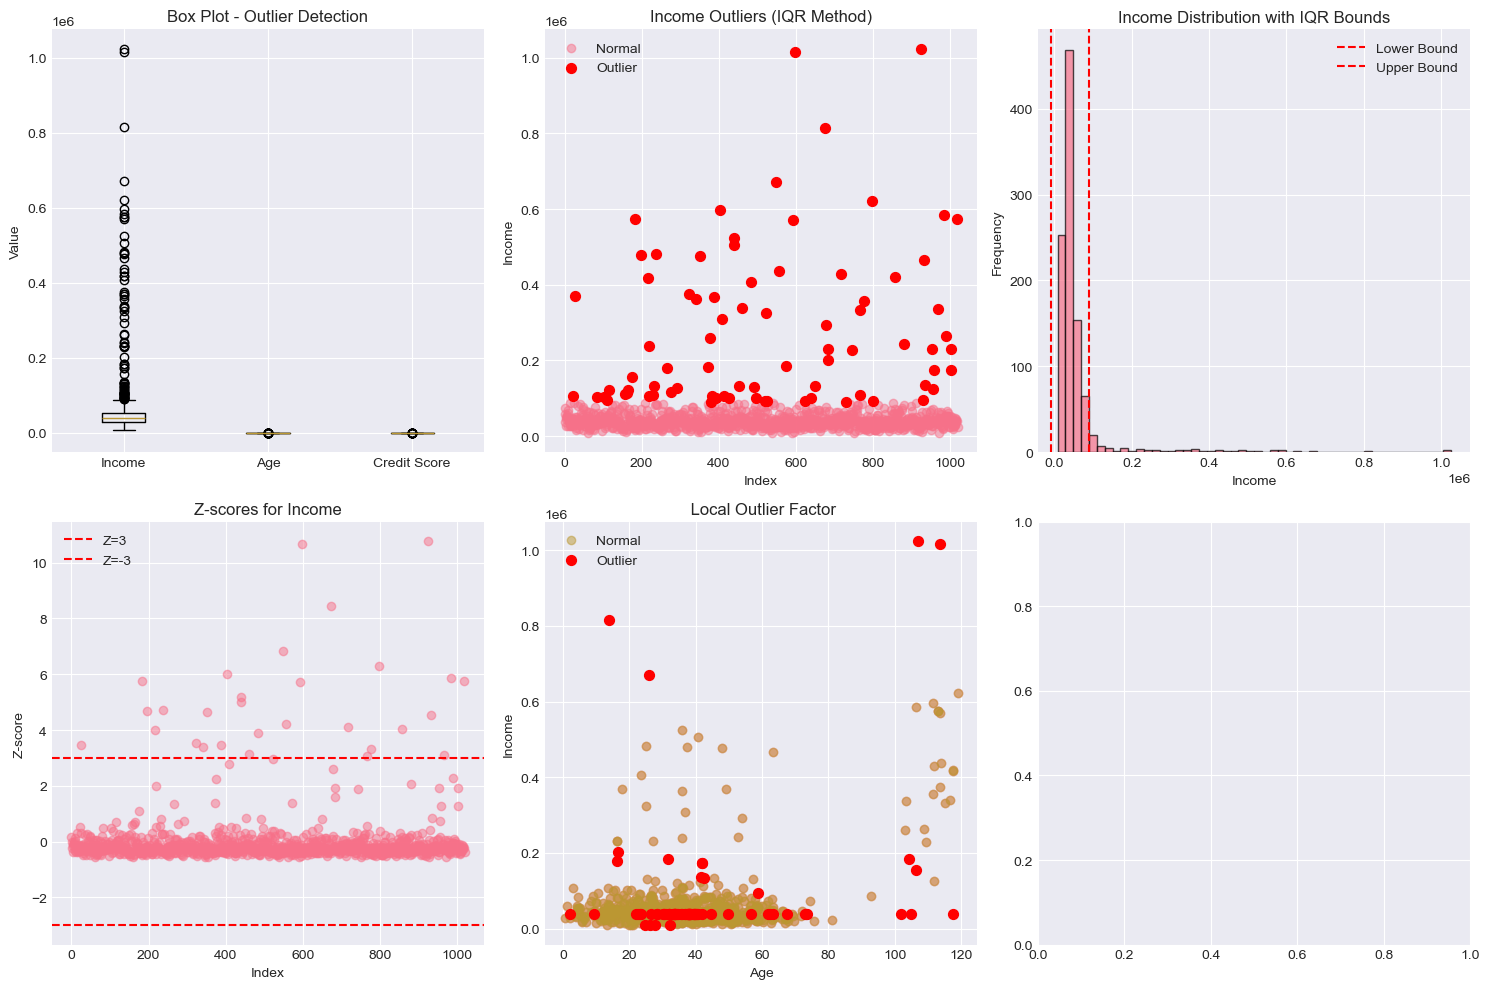

In [7]:
# 3.1 Outlier Detection Methods
print("🔍 OUTLIER DETECTION\n" + "="*40)

def detect_outliers(df, column, method='IQR'):
    """Detect outliers using various methods"""
    
    if method == 'IQR':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
    elif method == 'Z-score':
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        outliers = df[column].dropna()[z_scores > 3]
        
    elif method == 'Isolation Forest':
        from sklearn.ensemble import IsolationForest
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        outliers_pred = iso_forest.fit_predict(df[[column]].dropna())
        outliers = df[column].dropna()[outliers_pred == -1]
    
    return outliers

# Detect outliers in income
outliers_iqr = detect_outliers(df_imputed, 'income', 'IQR')
outliers_zscore = detect_outliers(df_imputed, 'income', 'Z-score')

print(f"Outliers detected in 'income':")
print(f"  IQR method: {len(outliers_iqr)} outliers")
print(f"  Z-score method: {len(outliers_zscore)} outliers")

# Visualize outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Box plot
ax = axes[0, 0]
ax.boxplot([df_imputed['income'], df_imputed['age'], df_imputed['credit_score']], 
           labels=['Income', 'Age', 'Credit Score'])
ax.set_title('Box Plot - Outlier Detection')
ax.set_ylabel('Value')

# Scatter plot with outliers
ax = axes[0, 1]
is_outlier = df_imputed['income'].isin(outliers_iqr['income'])
ax.scatter(df_imputed.index[~is_outlier], df_imputed.loc[~is_outlier, 'income'], 
          alpha=0.5, label='Normal')
ax.scatter(df_imputed.index[is_outlier], df_imputed.loc[is_outlier, 'income'], 
          color='red', label='Outlier', s=50)
ax.set_xlabel('Index')
ax.set_ylabel('Income')
ax.set_title('Income Outliers (IQR Method)')
ax.legend()

# Distribution with outlier boundaries
ax = axes[0, 2]
ax.hist(df_imputed['income'], bins=50, alpha=0.7, edgecolor='black')
Q1 = df_imputed['income'].quantile(0.25)
Q3 = df_imputed['income'].quantile(0.75)
IQR = Q3 - Q1
ax.axvline(Q1 - 1.5*IQR, color='red', linestyle='--', label='Lower Bound')
ax.axvline(Q3 + 1.5*IQR, color='red', linestyle='--', label='Upper Bound')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_title('Income Distribution with IQR Bounds')
ax.legend()

# Z-score visualization
ax = axes[1, 0]
z_scores = stats.zscore(df_imputed['income'])
ax.scatter(df_imputed.index, z_scores, alpha=0.5)
ax.axhline(y=3, color='red', linestyle='--', label='Z=3')
ax.axhline(y=-3, color='red', linestyle='--', label='Z=-3')
ax.set_xlabel('Index')
ax.set_ylabel('Z-score')
ax.set_title('Z-scores for Income')
ax.legend()

# Multivariate outlier detection
ax = axes[1, 1]
ax.scatter(df_imputed['age'], df_imputed['income'], alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_title('Bivariate Outlier Detection')

# Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)
outlier_labels = lof.fit_predict(df_imputed[['age', 'income']])
ax.scatter(df_imputed['age'][outlier_labels == 1], 
          df_imputed['income'][outlier_labels == 1], 
          alpha=0.5, label='Normal')
ax.scatter(df_imputed['age'][outlier_labels == -1], 
          df_imputed['income'][outlier_labels == -1], 
          color='red', label='Outlier', s=50)
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_title(' Local Outlier Factor')
ax.legend()

plt.tight_layout()
plt.show()

🔧 OUTLIER TREATMENT
1️⃣ Capping/Winsorization:
  income: Capped to [11353.93, 520884.34]
  age: Capped to [4.38, 112.90]

2️⃣ Log Transformation:
  Applied log transformation to income

3️⃣ Outlier Removal:
  Removed 94 rows


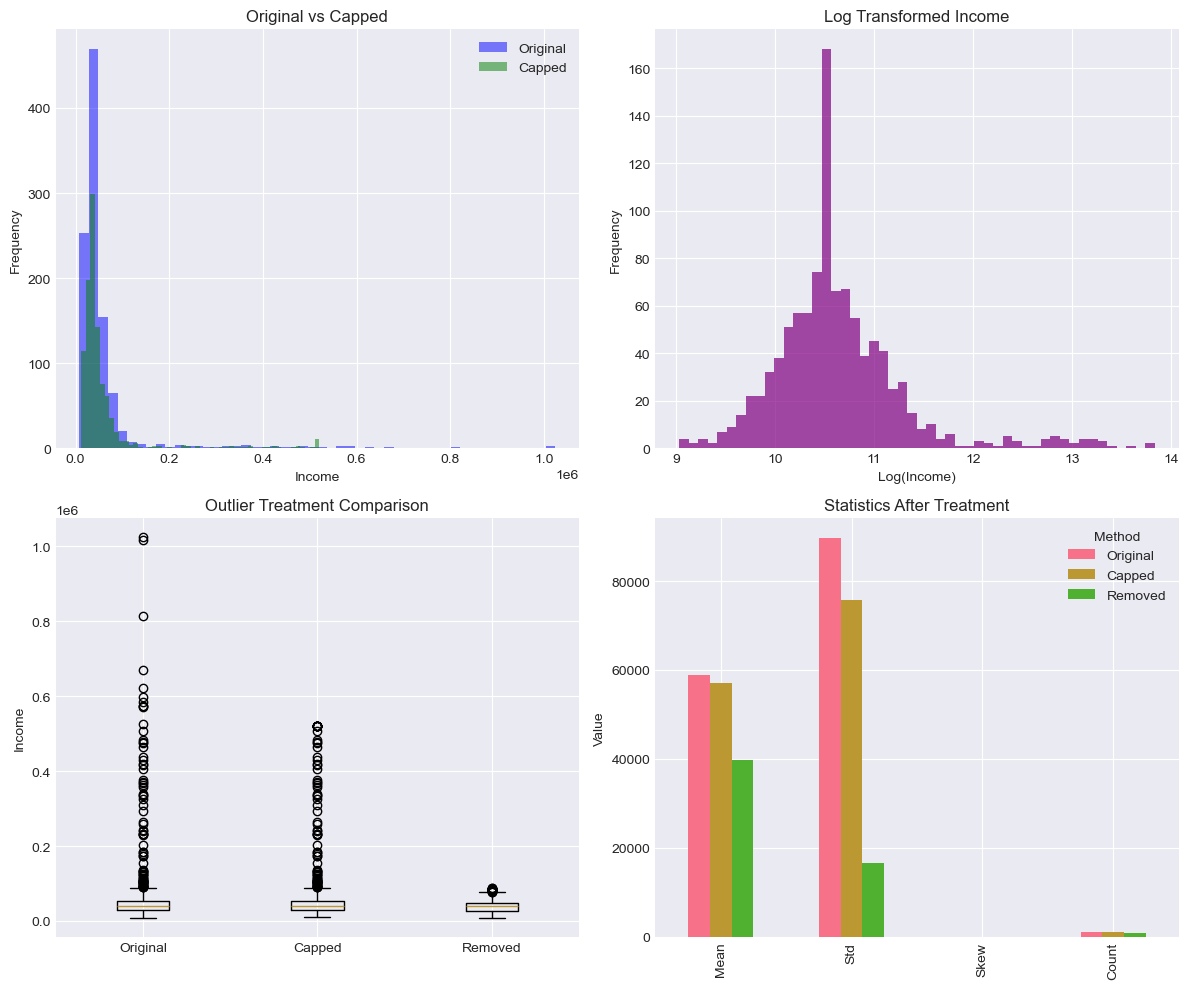


💡 When to use which method:
• Capping: Preserve all data, reduce extreme values
• Transformation: When distribution is skewed
• Removal: When outliers are errors or tiny %
• Keep: When outliers are valid and important


In [8]:
#  3.2 Outlier Treatment Strategies
print("🔧 OUTLIER TREATMENT\n" + "="*40)

# Create copies for different treatment methods
df_capped = df_imputed.copy()
df_transformed = df_imputed.copy()
df_removed = df_imputed.copy()

# Method 1: Capping (Winsorization)
print("1️⃣ Capping/Winsorization:")
for col in ['income', 'age']:
    Q1 = df_capped[col].quantile(0.01)
    Q99 = df_capped[col].quantile(0.99)
    df_capped[col] = df_capped[col].clip(Q1, Q99)
    print(f"  {col}: Capped to [{Q1:.2f}, {Q99:.2f}]")

# Method 2: Log Transformation
print("\n2️⃣ Log Transformation:")
df_transformed['income_log'] = np.log1p(df_transformed['income'])
print(f"  Applied log transformation to income")

# Method 3: Removal
print("\n3️⃣ Outlier Removal:")
before_shape = df_removed.shape
for col in ['income', 'age']:
    Q1 = df_removed[col].quantile(0.25)
    Q3 = df_removed[col].quantile(0.75)
    IQR = Q3 - Q1
    df_removed = df_removed[(df_removed[col] >= Q1 - 1.5*IQR) & 
                            (df_removed[col] <= Q3 + 1.5*IQR)]
after_shape = df_removed.shape
print(f"  Removed {before_shape[0] - after_shape[0]} rows")

# Visualize treatment effects
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original vs Capped
ax = axes[0, 0]
ax.hist(df_imputed['income'], bins=50, alpha=0.5, label='Original', color='blue')
ax.hist(df_capped['income'], bins=50, alpha=0.5, label='Capped', color='green')
ax.set_xlabel('Income')
ax.set_ylabel('Frequency')
ax.set_title('Original vs Capped')
ax.legend()

# Log transformation
ax = axes[0, 1]
ax.hist(df_transformed['income_log'], bins=50, alpha=0.7, color='purple')
ax.set_xlabel('Log(Income)')
ax.set_ylabel('Frequency')
ax.set_title('Log Transformed Income')

# Before/After boxplots
ax = axes[1, 0]
ax.boxplot([df_imputed['income'], df_capped['income'], df_removed['income']], 
           labels=['Original', 'Capped', 'Removed'])
ax.set_ylabel('Income')
ax.set_title('Outlier Treatment Comparison')

# Statistics comparison
ax = axes[1, 1]
stats_comparison = pd.DataFrame({
    'Original': [df_imputed['income'].mean(), df_imputed['income'].std(), 
                df_imputed['income'].skew(), len(df_imputed)],
    'Capped': [df_capped['income'].mean(), df_capped['income'].std(), 
              df_capped['income'].skew(), len(df_capped)],
    'Removed': [df_removed['income'].mean(), df_removed['income'].std(), 
               df_removed['income'].skew(), len(df_removed)]
}, index=['Mean', 'Std', 'Skew', 'Count'])

stats_comparison.plot(kind='bar', ax=ax)
ax.set_title('Statistics After Treatment')
ax.set_ylabel('Value')
ax.legend(title='Method')

plt.tight_layout()
plt.show()

print("\n💡 When to use which method:")
print("• Capping: Preserve all data, reduce extreme values")
print("• Transformation: When distribution is skewed")
print("• Removal: When outliers are errors or tiny %")
print("• Keep: When outliers are valid and important")

---

## 📌 Section 4: Feature Scaling and Transformation

### 🎯 Preparing Features for Machine Learning

In [ ]:
# 4.1 Feature Scaling Methods
print("⚖️ FEATURE SCALING\n" + "="*40)

# Select numeric features
features = ['age', 'income', 'credit_score', 'purchase_amount', 'membership_days']
X = df_capped[features].copy()

# Different scaling methods
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

scalers = {
    'Original': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}

# Apply scaling
scaled_data = {}
for name, scaler in scalers.items():
    if scaler is None:
        scaled_data[name] = X
    else:
        scaled_data[name] = pd.DataFrame(
            scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )

# Visualize scaling effects
fig, axes = plt.subplots(len(features), len(scalers), figsize=(20, 15))

for i, feature in enumerate(features):
    for j, (name, data) in enumerate(scaled_data.items()):
        ax = axes[i, j]
        ax.hist(data[feature], bins=30, alpha=0.7, edgecolor='black')
        ax.set_title(f'{feature}\n{name}')
        
        # Add statistics
        mean = data[feature].mean()
        std = data[feature].std()
        ax.axvline(mean, color='red', linestyle='--', alpha=0.5)
        ax.text(0.7, 0.9, f'μ={mean:.2f}\nσ={std:.2f}', 
               transform=ax.transAxes, fontsize=8)

plt.suptitle('Feature Scaling Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 Scaling Method Comparison:")
print("• StandardScaler: Mean=0, Std=1 (assumes normal distribution)")
print("• MinMaxScaler: Range [0,1] (preserves original distribution)")
print("• RobustScaler: Uses median/IQR (robust to outliers)")
print("• PowerTransformer: Makes data more Gaussian-like")

---

## 📌 Section 5: Feature Engineering

### 🎯 Creating Powerful Features

In [ ]:
# 5.1 Feature Engineering Techniques
print("🛠️ FEATURE ENGINEERING\n" + "="*40)

# Create new features
df_engineered = df_capped.copy()

# Temporal features
df_engineered['account_age_years'] = df_engineered['membership_days'] / 365
df_engineered['account_age_category'] = pd.cut(df_engineered['account_age_years'], 
                                                bins=[0, 1, 2, 5, 10], 
                                                labels=['New', 'Regular', 'Loyal', 'VIP'])

# Ratio features
df_engineered['income_per_age'] = df_engineered['income'] / df_engineered['age']
df_engineered['purchase_to_income_ratio'] = df_engineered['purchase_amount'] / df_engineered['income']
df_engineered['credit_score_category'] = pd.cut(df_engineered['credit_score'],
                                                 bins=[300, 580, 670, 740, 800, 850],
                                                 labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

# Interaction features
df_engineered['high_income_good_credit'] = (
    (df_engineered['income'] > df_engineered['income'].median()) & 
    (df_engineered['credit_score'] > 700)
).astype(int)

# Polynomial features
df_engineered['age_squared'] = df_engineered['age'] ** 2
df_engineered['income_log'] = np.log1p(df_engineered['income'])

# Binning continuous variables
df_engineered['age_group'] = pd.cut(df_engineered['age'], 
                                    bins=[0, 25, 35, 50, 65, 100],
                                    labels=['<25', '25-35', '35-50', '50-65', '65+'])

print("📊 New Features Created:")
new_features = ['account_age_years', 'account_age_category', 'income_per_age', 
                'purchase_to_income_ratio', 'credit_score_category', 
                'high_income_good_credit', 'age_squared', 'income_log', 'age_group']
for feat in new_features:
    print(f"  • {feat}")

# Visualize engineered features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Age groups distribution
ax = axes[0, 0]
df_engineered['age_group'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Age Group Distribution')
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')

# Credit score categories
ax = axes[0, 1]
df_engineered['credit_score_category'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_title('Credit Score Categories')

# Income per age
ax = axes[0, 2]
ax.scatter(df_engineered['age'], df_engineered['income_per_age'], alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Income per Age')
ax.set_title('Income/Age Ratio')

# Purchase to income ratio
ax = axes[1, 0]
ax.hist(df_engineered['purchase_to_income_ratio'], bins=30, edgecolor='black')
ax.set_xlabel('Purchase/Income Ratio')
ax.set_ylabel('Frequency')
ax.set_title('Purchase to Income Ratio')

# Account age categories
ax = axes[1, 1]
df_engineered['account_age_category'].value_counts().plot(kind='bar', ax=ax)
ax.set_title('Customer Loyalty Categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')

# Feature correlation heatmap
ax = axes[1, 2]
numeric_features = df_engineered[['age', 'income', 'credit_score', 
                                  'income_per_age', 'purchase_to_income_ratio']].corr()
sns.heatmap(numeric_features, annot=True, fmt='.2f', cmap='coolwarm', ax=ax)
ax.set_title('Feature Correlations')

plt.tight_layout()
plt.show()